# Run the experiment
After processing the data, the neural network can be trained

## Setting up the model

In [1]:
import sys
import h5py
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

%cd ..

/c/Users/u0124144/Documents/DTW_measure


In [2]:
from src.model.LSTMnn import LSTMnn

Retrieve the datasets:

In [3]:
def load_training_sets(fname='data/processed/datasets.h5'):
    with h5py.File(fname, 'r') as f:
        train_in = f['train_sets/train_in'][:]
        train_out = f['train_sets/train_out'][:]
        valid_in = f['valid_sets/valid_in'][:]
        valid_out = f['valid_sets/valid_out'][:]
    return train_in, train_out, valid_in, valid_out

train_in, train_out, valid_in, valid_out = load_training_sets()

Now define the hyperparameters that are used during the training of the neural network

In [4]:
time_forward = train_out.shape[2]
time_back = train_in.shape[1]
num_epochs = 30
hidden_size = 50
momentum = 0.8
num_layers = 1
learning_rate = 0.0003
batch_size = 64
num_feat = train_in.shape[2]

The numpy datasets need to be converted to pytorch tensors.

In [5]:
def numpy_to_dataloader(input_, output_, batch_size=64):
    set_ = TensorDataset(torch.Tensor(input_), torch.Tensor(output_))
    return DataLoader(set_, batch_size=batch_size, shuffle=True)

train = numpy_to_dataloader(train_in, train_out, batch_size)
valid = numpy_to_dataloader(valid_in, valid_out, 1024)

Next the model is set up. A criterion and optimizer is defined, using the hyperparameters previously defined

In [6]:
model = LSTMnn(num_feat, num_layers, hidden_size, time_forward)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum)

## Training the model

In [7]:
def train_model(model, epochs, training, validation, criterion, optimizer, file_path=None, verbal=False):
    '''Train the model, using validation set for best selection
    The model is trained on the training data. Each epoch, the model is than used to predict the validation data.
    The best iteration of the model is stored and returned after going through every epoch.
    If a file_path is given, the best model configuration is stored in a file.
    '''
    min_val = np.inf
    best_loss = np.inf
    best_epoch = 0
    best_model = None
    for t in range(epochs):
        running_loss = 0
        model.train()
        for x, y in training:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if verbal:
            print('Epoch {}: Training loss: {}'.format(t, running_loss/len(training.dataset)))

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_in, val_out in validation:
                y_pred = model(val_in)
                loss = criterion(val_out, y_pred)
                val_loss += loss.item()
            if verbal:
                print('Validation loss: ', val_loss / len(validation.dataset))
            if val_loss < min_val:
                min_val = val_loss
                best_loss = running_loss/len(training.dataset)
                best_epoch = t
                best_model = model.state_dict()
    if file_path is not None:
        torch.save(best_model, file_path)
    print('Best loss: {}, Min validation loss: {}, Epoch: {}'.format(best_loss, min_val, best_epoch))

    model.load_state_dict(best_model)

In [8]:
model_file = 'models/notebook_model'
train_model(model, num_epochs, train, valid, criterion, optimizer, verbal=True, file_path=model_file)

Epoch 0: Training loss: 2.9556030877833117
Validation loss:  0.10515459169293209
Epoch 1: Training loss: 1.5051074923118202
Validation loss:  0.08756027136026145
Epoch 2: Training loss: 1.2640917129144227
Validation loss:  0.10397199699649472
Epoch 3: Training loss: 1.1618238736780346
Validation loss:  0.07903124600387296
Epoch 4: Training loss: 1.1008844799582838
Validation loss:  0.07710712290364982
Epoch 5: Training loss: 1.0641551114200496
Validation loss:  0.07507611975715607
Epoch 6: Training loss: 1.035504703734551
Validation loss:  0.07386467928398772
Epoch 7: Training loss: 1.0097550383233946
Validation loss:  0.07388431204900762
Epoch 8: Training loss: 0.9910390142894775
Validation loss:  0.07098888985890227
Epoch 9: Training loss: 0.9717762381172538
Validation loss:  0.07225057723011671
Epoch 10: Training loss: 0.9561947460836704
Validation loss:  0.07116325224241594
Epoch 11: Training loss: 0.9450437813232879
Validation loss:  0.07175173217312465
Epoch 12: Training loss: 0.

KeyboardInterrupt: 

## Testing the model

First the test data is loaded and the model is used to create a forecast.

In [8]:
def load_testing_sets(fname='data/processed/datasets.h5'):
    with h5py.File(fname, 'r') as f:
        test_in = f['test_sets/test_in'][:]
        test_out = f['test_sets/test_out'][:]
        lookup = f['test_sets/lookup'][:]
    return test_in, test_out, lookup.astype('datetime64[s]')

def run_model(model, data_in, file_path=None):
    if file_path is not None:
        model.load_state_dict(torch.load(file_path))
    model.eval() 
    pred = model(torch.Tensor(data_in))
    return pred.detach().numpy()

test_in, test_out, lookup = load_testing_sets()
predict = run_model(model, test_in, file_path='models/notebook_model')

In [9]:
import pandas as pd
from src.model.metrics import evaluate
ev = evaluate(predict[:, 0], test_out[:, 0])
pd.DataFrame(data=ev, index=['t+{}'.format(i+1) for i in range(6)])

,A,B,sigmaA,sigmaB,R,RMSE,MAE,ME,PE
t+1,-0.814788,0.963768,0.122550,0.005486,0.979618,3.778759,2.392402,-0.372800,0.959237
t+2,-1.373954,0.913792,0.119742,0.005363,0.949968,5.854383,3.857594,-0.322643,0.901998
t+3,-2.056741,0.863452,0.116940,0.005242,0.918334,7.415855,4.899627,-0.392314,0.842417
t+4,-2.572939,0.823085,0.114773,0.005150,0.891091,8.501020,5.575145,-0.417822,0.792480
t+5,-2.953462,0.791753,0.113210,0.005084,0.868341,9.292625,6.035635,-0.418307,0.751624
t+6,-3.340108,0.760450,0.111327,0.005002,0.847621,9.940575,6.401560,-0.425987,0.715485


##  Observe the forecasted storms

In [11]:
def load_test_storm_dates(fname='data/processed/datasets.h5'):
    with h5py.File(fname, 'r') as f:
        test_storm_dates = f['test_sets/storms/storm_dates'][:]
    return test_storm_dates.astype('datetime64')

test_storm_dates = load_test_storm_dates()

In [12]:
test_storm_dates = test_storm_dates.astype('datetime64')

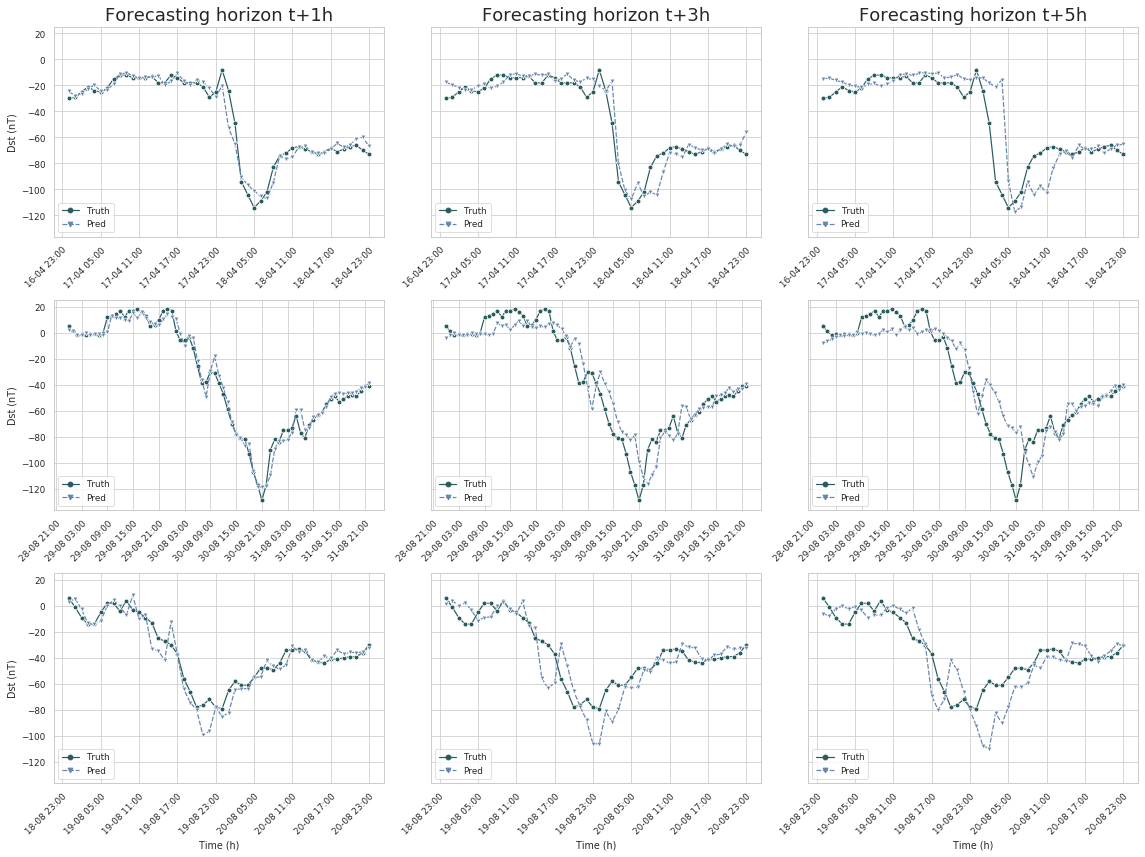

In [17]:
from src.visualize.visualize import plot_set_of_storms
times = [0, 2, 4]
selected_storms = [test_storm_dates[0], test_storm_dates[7], test_storm_dates[13]]
plot_set_of_storms(test_out[:, 0], predict[:, 0], lookup, selected_storms, times, save=False)

### Store the results

In [18]:
def save_test_forecast(fname='data/processed/datasets.h5'):
    with h5py.File(fname, 'a') as f:
        f['test_sets'].create_dataset('prediction', data=predict)
save_test_forecast()